In [ ]:
import torch
from torch.utils.data import DataLoader

from Models import JointAutoregressiveHierarchical #, HierarchicalMixtureResidual
from Dataloader import PreprocessedDataset, KodakDataset
from RateDistortionLoss import rd_loss
from Trainer import Trainer
from Evaluator import CompressionEvaluator

### Prepare Dataset

In [6]:
preprocessed_dir1 = "./data/coco_preprocessed"
train_dataset1 = PreprocessedDataset(preprocessed_dir1)
train_loader1 = DataLoader(train_dataset1, batch_size=16, shuffle=True)

preprocessed_dir2 = "./data/DIV2K_preprocessed"
train_dataset2 = PreprocessedDataset(preprocessed_dir2)
train_loader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)

kodak_dir = "./data/kodak"
val_dataset = KodakDataset(kodak_dir)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

### Training

In [ ]:
# device
device = "cuda" if torch.cuda.is_available() else "cpu"

# model
K = 3
model = JointAutoregressiveHierarchical(latent_channels=128, K=K).to(device)

# Hyperparameters
lambda_rd = 0.005

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# directories
logdir= f"runs/experiment_lambda_{lambda_rd}_K_{K}"
checkpoint_path= "./checkpoints/checkpoint.pth"

# trainer
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader1, 
    val_loader=val_loader,
    rd_loss=rd_loss,
    lambda_val=lambda_rd,
    max_steps=100000,
    resume=True,
    #log_interval=10,
    #img_interval=50,
    #val_interval=20,
    scheduler=None,
    log_dir=logdir,
    checkpoint_path=checkpoint_path,
    device=device             
)

# start training
trainer.train()

### Evaluation

In [4]:
evaluator = CompressionEvaluator(model, val_loader, device, lambda_rd)
avg_metrics, imgs_list, recon_list = evaluator.evaluate(rd_loss)


--- Evaluation Results ---
MSE(255): 84.009519
PSNR(RGB): 29.545531
MS-SSIM(RGB): 0.950895
PSNR(Y): 30.011898
MS-SSIM(Y): 0.958053
BPP: 0.225892
BPP(y): 0.225892
BPP(z): 0.005891


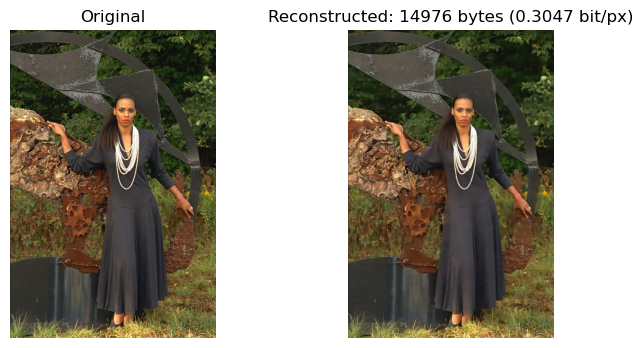

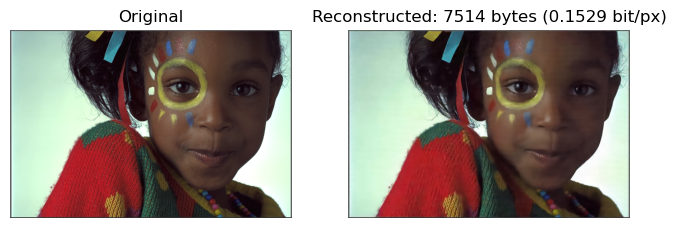

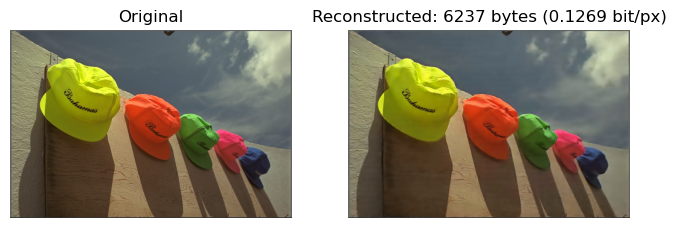

In [5]:
evaluator.plot_samples(imgs_list, recon_list, rd_loss, n=3)

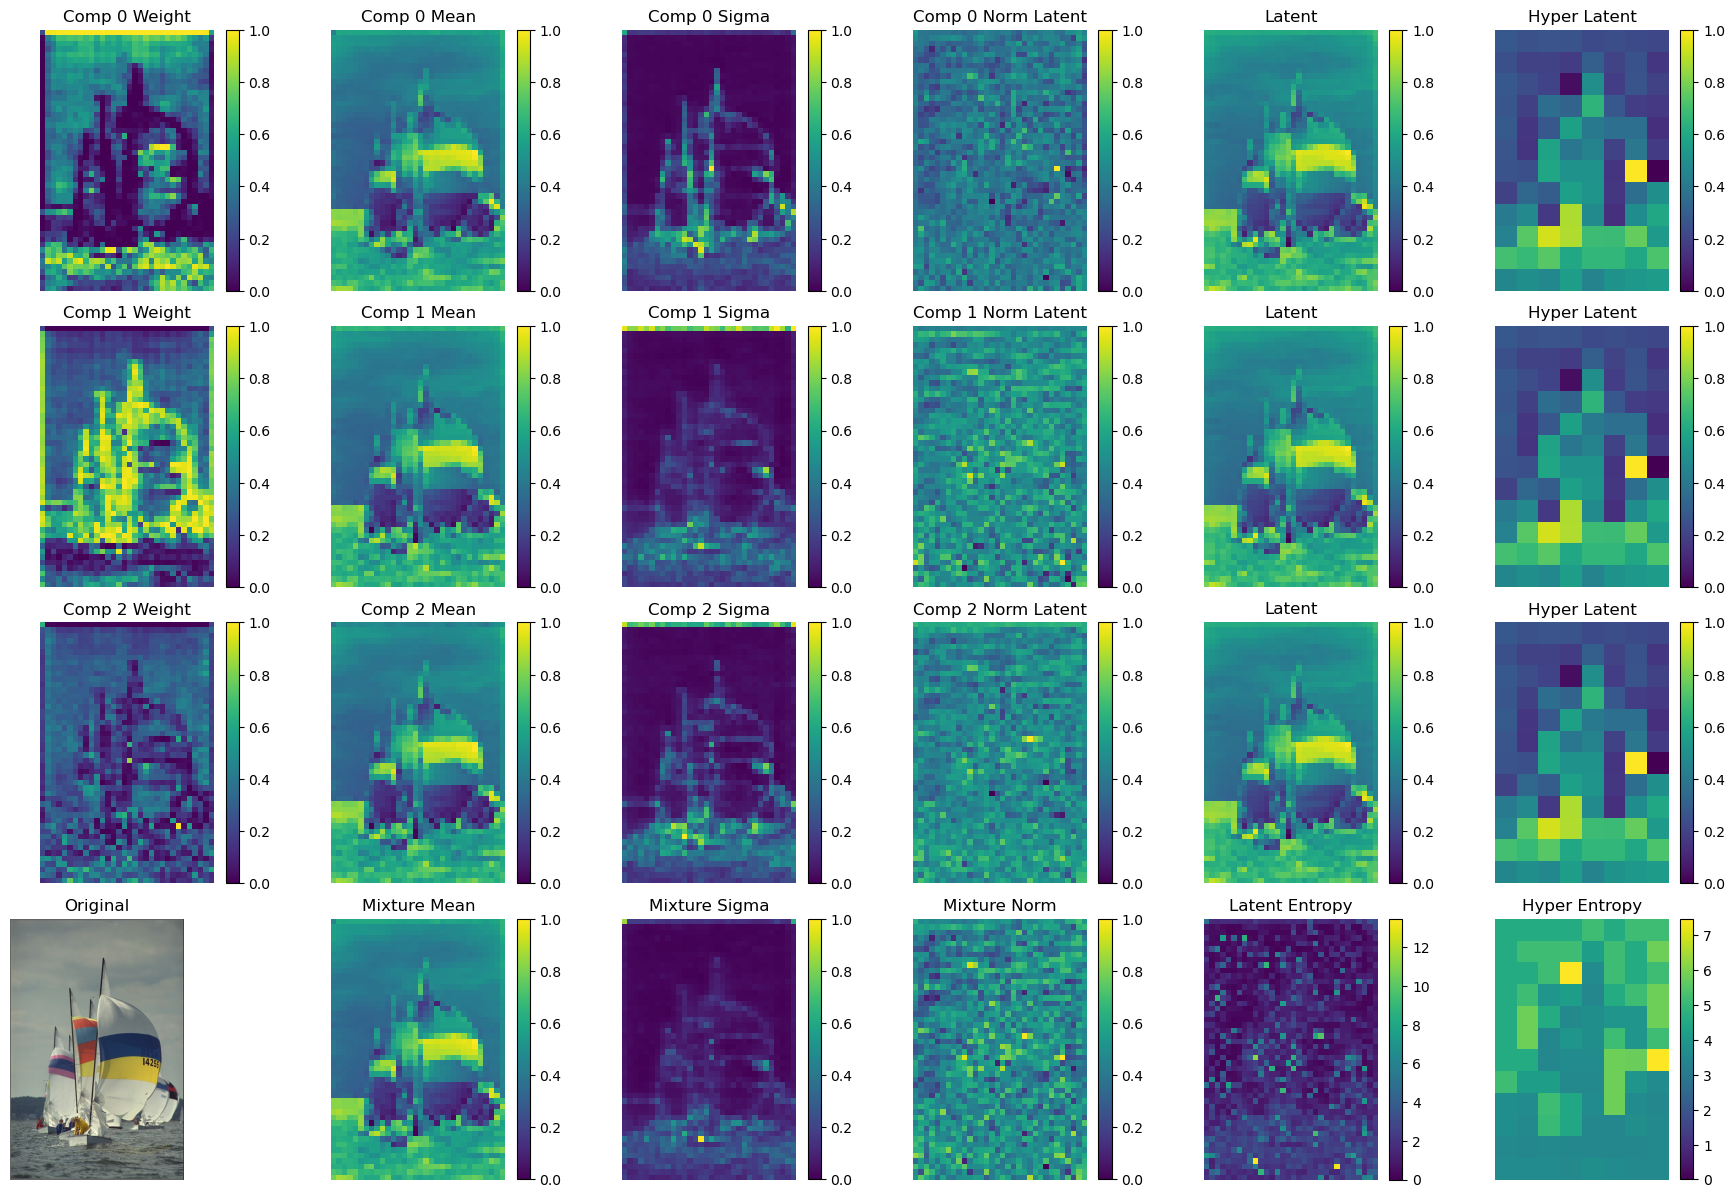

In [6]:
evaluator.plot_high_entropy_channel(imgs_list)

In [9]:
evaluator.save_results(avg_metrics, nb_steps=200000, caption=f"GM-Capacity128_K{K}")

Results saved to ./eval_results\eval_results_0.005_lambda_GM-Capacity128_K3.txt
